In [1]:
import numpy as np
from matplotlib import pyplot as plt
import numba as nb

In [77]:
def get_samples(delay,mult,k,dk,N=4096,snr=10,plot=True):
    N=N*mult
    dk=int(dk*mult)
    num_k = len(k)
    rns=np.random.randn(2*dk*num_k+4*(N//2+1))
#     rr=np.sqrt(100)*np.random.randn(dk*num_k)
#     ir=np.sqrt(100)*np.random.randn(dk*num_k)
    fr=np.zeros(N//2+1)
    fi=np.zeros(N//2+1)
    bb=num_k*dk
    x_new = np.zeros(N,dtype="complex128")
    x2_new = x_new.copy()
    for i,j in enumerate(k):
        j= int(j*mult)
        fr[j-dk//2:j+dk//2]=np.sqrt(snr)*rns[i*dk:(i+1)*dk]
        fi[j-dk//2:j+dk//2]=np.sqrt(snr)*rns[bb+i*dk:bb+(i+1)*dk]
    bb+=num_k*dk
    size=N//2+1
    x_new[:N//2+1]=fr+rns[bb:bb+size]+1J*(fi+rns[bb+size:bb+2*size])
    x_new = N*np.fft.ifft(x_new)

    bb+=2*size
    x2_new[:N//2+1] = (fr+1J*fi)*np.exp(-2J*np.pi*np.arange(0,N//2+1)*delay/N) + rns[bb:bb+size]+1J*rns[bb+size:bb+2*size]
    x2_new = N*np.fft.ifft(x2_new)
    
    if plot:
        plt.plot(np.abs(np.fft.fft(x2_new)))
    return x_new, x2_new

In [86]:
mult=5000
delay=200.8
print(delay/4096)
# k=np.arange(1834,)+0.1
# dk=0.3
k = np.asarray([182, 250]) + 0.1

# x1,x2=get_samples(-500000.5,mult,k=(1839.2,1835.2,1845.2,1849.2),dk=0.4,plot=True)
x1,x2=get_samples(delay,mult,k=k,dk=25,snr=2,plot=False)

0.0490234375


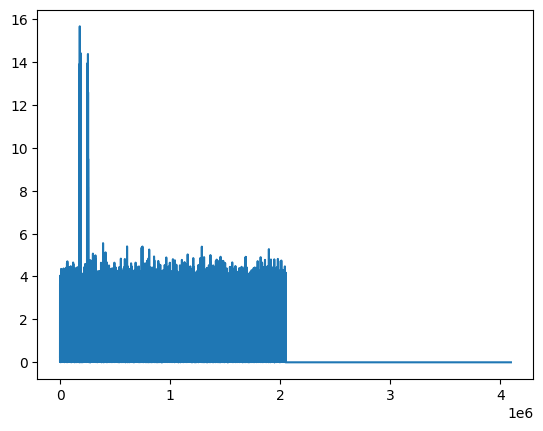

In [58]:
plt.plot(np.abs(np.fft.fft(x1)))
# plt.xlim(182000-1000,185000+1000)

In [12]:
@nb.njit()
def qq(x):
    return 2*(x>0)-1
@nb.njit()
def quantize(ts):
    return qq(np.real(ts)) + 1j*qq(np.imag(ts))
def get_quant_parts(Qts,Qts2):
    r0,im0 = np.real(Qts), np.imag(Qts)
    r1,im1 = np.real(Qts2), np.imag(Qts2)
    return np.mean(r0*r1), np.mean(im0*im1), np.mean(im0*r1), np.mean(r0*im1)
@nb.njit()
def get_quant_parts_phased(Qts,Qts2,phase,power):
    r0,im0 = np.real(Qts), np.imag(Qts)
    r1,im1 = np.real(Qts2), np.imag(Qts2)
    cc=np.cos(phase)
    ss=np.sin(phase)
    cph,sph=qq(cc),qq(ss)
    aa=np.mean(r0*r1*cph)
    bb=np.mean(r0*im1*sph)
    RR=np.sin(np.pi*aa/2)*power*np.abs(cc)-np.sin(np.pi*bb/2)*power*np.abs(ss)
    aa=np.mean(im0*r1*sph)
    bb=np.mean(im0*im1*cph)
    II=np.sin(np.pi*aa/2)*power*np.abs(ss)+np.sin(np.pi*bb/2)*power*np.abs(cc)
    aa=np.mean(im0*r1*cph)
    bb=np.mean(im0*im1*sph)
    IR=np.sin(np.pi*aa/2)*power*np.abs(cc)-np.sin(np.pi*bb/2)*power*np.abs(ss)
    aa=np.mean(r0*r1*sph)
    bb=np.mean(r0*im1*cph)
    RI=np.sin(np.pi*aa/2)*power*np.abs(ss)+np.sin(np.pi*bb/2)*power*np.abs(cc)
    return RR,II,IR,RI

In [2]:
#this is real timestream
niter=1
osamp=30000
N=4096*osamp
nchan=N//2
mean_vals = np.zeros(niter,dtype="complex128")
std_vals = np.zeros(niter,dtype="complex128")
snr = 3
wnoise = 2
k=50*osamp
dk=3*osamp
std_vals = []
cx_vals = []
auto_vals = []
cx0 = []
cx1 = []
cx2 = []
cx3 = []
delay=25
for i in range(niter):
    f=np.zeros(N//2+1,dtype="complex128")
    # rng=prng.MultithreadedRNG(N+2)
    # rng.fill()
#     f[:]=(rng.values[:N//2+1] + 1j*rng.values[N//2+1:])
    f[k-dk//2:k+dk//2] = f[k-dk//2:k+dk//2] + np.sqrt(snr*N/dk) * (np.random.randn(dk) + 1j * np.random.randn(dk)) # sqrtN here gets rid of one N
    f2=f.copy()
    f2[:]+=np.sqrt(wnoise)*(np.random.randn(len(f))+ 1j * np.random.randn(len(f)))
    #add delay
    f2[:]=f2*np.exp(-2J*np.pi*np.arange(0,N//2+1)*delay/N)
    ts2 = np.sqrt(N)*np.fft.ifft(np.hstack([f2,np.zeros(N//2-1)]))
    f[:]+=np.sqrt(wnoise)*(np.random.randn(len(f))+ 1j * np.random.randn(len(f)))
    ts = np.sqrt(N)*np.fft.ifft(np.hstack([f,np.zeros(N//2-1)])) # sqrtN here gets rid of one more N in denom
    cx_vals.append(np.mean(ts[:]*np.conj(ts2[:])))
    auto_vals.append(np.mean(ts*np.conj(ts)))
    # Qts = quantize(ts)
    # Qts2 = quantize(ts2)
    # r0,im0 = np.real(Qts), np.imag(Qts)
    # r1,im1 = np.real(Qts2), np.imag(Qts2)
    # cx0.append(np.mean(r0*r1))
    # cx1.append(np.mean(im0*im1))
    # cx2.append(np.mean(im0*r1))
    # cx3.append(np.mean(im1*r0))
    # ts = np.sqrt(N)*np.fft.irfft(f)
    # std_vals.append(np.std(ts))

In [69]:
#with signal - for real timestream multiply whole thing by 2
print("expected stddev of timestream = ", np.sqrt(dk * snr * 2))

expected stddev of timestream =  15.491933384829668


In [3]:
#without signal
print("stddev of timestream = ", np.mean(std_vals))
print("expected stddev of timestream = ", np.sqrt(25*2))

stddev of timestream =  nan
expected stddev of timestream =  7.0710678118654755


/home/mohan/.envs/xcorr/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mohan/.envs/xcorr/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [169]:
#without signal
print("stddev of timestream = ", np.sqrt(np.mean(auto_vals).real))
print("expected stddev of timestream = ", np.sqrt(wnoise + dk * snr * 2))
print("signal only stddev of timestream = ", np.sqrt(dk * snr * 2))

stddev of timestream =  2.8404606235075764
expected stddev of timestream =  424.2664257279852
signal only stddev of timestream =  424.26406871192853


In [4]:
#without signal
print("stddev of timestream = ", np.sqrt(np.mean(auto_vals).real))
print("expected stddev of timestream = ", np.sqrt(wnoise + snr * 2))
print("signal only stddev of timestream = ", np.sqrt(snr * 2))

stddev of timestream =  2.830602060389696
expected stddev of timestream =  2.8284271247461903
signal only stddev of timestream =  2.449489742783178


In [6]:
print("xcorr",cx_vals) # depends on amount of delay
print("acorr",auto_vals)

xcorr [(-2.0399875530349143+5.640668265021631j)]
acorr [(8.001378680109138-1.1036026752408083e-20j)]


In [6]:
snr * 2 #no delay

6

In [4]:
snr * 2 * np.sinc(dk * delay/N) * np.exp(2J*np.pi*k*delay/N) # normalized my simulation by the BW

(-2.0375371562185047+5.639924763652772j)

print(RR,II,IR,RI) # this is unquantized for comparison

-1.0184209470435346 -1.018421001631916 2.82004716125337 -2.820047214230537

In [5]:
get_quant_parts(ts,ts2)

(-1.019993795242553,
 -1.0199937577923568,
 2.820334122864781,
 -2.820334142156841)

In [7]:
k,N,ts2.shape


(1500000, 122880000, (122880000,))

In [32]:
alpha=1e-7 #seconds per sample
ts2_new = ts2*np.exp(-2J*np.pi*k*alpha*np.arange(len(ts))/N)

In [33]:
print(np.mean(np.abs(ts2_new)**2)) #matches the autocorr we'd expect

8.02776053121765


In [34]:
np.max(ts2_new[:]-ts2[:])

(9.065974284108862-2.0022595935067127j)

In [44]:
N*1e-7 #these many extra sec of delay

12.288

In [54]:
RR,II,IR,RI = get_quant_parts(quantize(ts),quantize(ts2))
print(RR,II,IR,RI)

-0.163870703125 -0.16390869140625 0.49874021809895835 -0.498658544921875


In [15]:
np.sin(np.pi*RR/2)*(wnoise + snr * 2)/2, np.sin(np.pi*IR/2)*(wnoise + snr * 2)/2

(-1.0182972933622556, 2.8228245269822287)

In [55]:
phi=2*np.pi*k*delay/N
print((np.sin(np.pi*RR/2)*np.cos(phi)-np.sin(np.pi*RI/2)*np.sin(phi))*(wnoise + snr * 2)/2)
print((np.sin(np.pi*IR/2)*np.sin(phi)+np.sin(np.pi*II/2)*np.cos(phi))*(wnoise + snr * 2)/2)
#above two terms are the real part
print((np.sin(np.pi*RR/2)*np.sin(phi)+np.sin(np.pi*RI/2)*np.cos(phi))*(wnoise + snr * 2)/2)
print((np.sin(np.pi*IR/2)*np.cos(phi)-np.sin(np.pi*II/2)*np.sin(phi))*(wnoise + snr * 2)/2)
#above two terms are the imag part

# we see that net = 6 + 0j
#dont have d

3.0005355129303237
3.000955913433709
0.001292192375199952
-0.0011986478002172785


In [51]:
get_quant_parts(ts,ts2*np.exp(2J*np.pi*k*delay/N))

(3.0124963883111175,
 3.012496413602335,
 -0.0009690317985463599,
 0.0009689620573099914)

In [14]:
cx_phased = np.mean(ts*np.conj(ts2*np.exp(2J*np.pi*k*delay/N)))

In [15]:
cx_phased #phasing works without quantization

(6.009781178469388+0.0002483530805673692j)

1. try removing phase from the new method
2. check the VV works with a varying phase normally
3. try removing the varying phase by new method

In [58]:
Qts=quantize(ts)
Qts2=quantize(ts2)
Qts2_new=quantize(ts2_new)
Qts2_phased=Qts2*np.exp(-2J*np.pi*k*1e-7*np.arange(len(ts))/N)
# Qts2_new_phased = Qts2_new*np.exp(2J*np.pi*k*alpha*np.arange(len(ts))/N)

In [41]:
RR,II,IR,RI = get_quant_parts(quantize(ts),quantize(ts2))
print(RR,II,IR,RI)

-0.163870703125 -0.16390869140625 0.49874021809895835 -0.498658544921875


In [43]:
RR,II,IR,RI = get_quant_parts(quantize(ts),quantize(ts2_new))
print(RR,II,IR,RI)

-0.3589353515625 -0.35898370768229165 0.3339959147135417 -0.333959375


In [57]:
RR,II,IR,RI = get_quant_parts(quantize(ts),Qts2_phased)
print(RR,II,IR,RI)

-0.16410604197965703 -0.16414407693742125 0.4986627974462737 -0.4985811274535046


In [59]:
phase=2*np.pi*k*alpha*np.arange(len(ts))/N
power=(wnoise + snr * 2)/2
get_quant_parts_phased(Qts,Qts2,phase,power)

(array([-1.01829729, -1.01829727, -1.01829725, ...,  1.6848786 ,
         1.68487862,  1.68487864]),
 array([-1.01852811, -1.01852809, -1.01852807, ...,  1.68503709,
         1.68503711,  1.68503713]),
 array([2.82282453, 2.82282453, 2.82282454, ..., 2.48322114, 2.48322113,
        2.48322111]),
 array([-2.82246092, -2.82246093, -2.82246094, ..., -2.48282084,
        -2.48282083, -2.48282081]))

In [48]:
get_quant_parts(quantize(ts),quantize(ts2*np.exp(-2J*np.pi*k*alpha*np.arange(len(ts))/N)))

(-0.3589353515625, -0.35898370768229165, 0.3339959147135417, -0.333959375)

In [51]:
np.sin(np.pi*RR/2)*(wnoise + snr * 2)/2, np.sin(np.pi*IR/2)*(wnoise + snr * 2)/2

(-2.1358551926892297, 2.003371584828504)

Above doesn't match. most probably because this extra phase is not random.

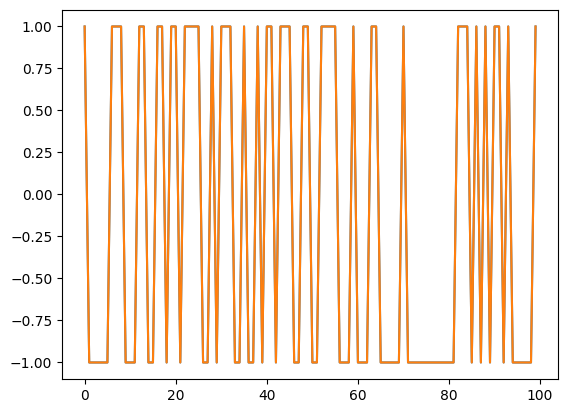

In [45]:
cos_phi_t = np.cos(2*np.pi*3*np.arange(100)/100)
Qts_cos_phi = np.sign(Qts.real[:100]*cos_phi_t)
# plt.plot(ts.real[:100])
plt.plot(Qts.real[:100])
# plt.plot(Qts_cos_phi)
plt.plot(Qts_cos_phi*np.sign(cos_phi_t))
# plt.plot(cos_phi_t)
# plt.plot(ts.real[:100]*cos_phi_t)

Let's do a simple exercise. calculate r0r1cosphi and r0im1sinphi

In [ ]:
Qts

In [63]:
get_quant_parts(Qts,Qts2) #just verifying that new quantize function is correct

(-0.163980908203125,
 -0.16395109049479167,
 0.4982280110677083,
 -0.4982826334635417)

In [98]:
np.var(np.imag(ts2_new))

4.006708438680447

Imaginary or real part of Z*exp(j$\phi$) is composed of two parts.
E.g. $Z_{im} = r_1sin(\phi)+im_1cos(\phi)$

If you compute the variance, of $Z_{im}$ sin and cos will add to one. Even if the phase is varying in time, and you estimate the variance like (not showing the cross terms since r and im are IID)

$\hat{\sigma}^2 = \frac{1}{N}\sum_i r_i^2 sin^2(\phi_i) + im_i^2 cos^2(\phi_i) $

sin and cos pairs will always disappear.Hence variance doesn't change. But if you were looking at variance of just $r_1 cos(\phi)$, it'll be different from that of $r_1$.

In [9]:
phi=2*np.pi*k*delay/N
power=(wnoise + snr * 2)/2
get_quant_parts_phased(Qts,Qts2,phi,power)

(2.997995556584062,
 2.998156923947658,
 0.0012414713741079053,
 -0.0013144882959890136)

In [99]:
#do same thing but with changing delay

In [20]:
alpha=1e-6 #seconds per second
ts2_new = ts2*np.exp(-2J*np.pi*k*alpha*np.arange(len(ts))/N)
phi=2*np.pi*k*(delay+alpha*np.arange(len(ts)))/N
Qts2_new=quantize(ts2_new)

In [28]:
power=(wnoise + snr * 2)/2

In [45]:
block=5000
new_parts = np.zeros((N//block,4),dtype="float64")
for i in range(new_parts.shape[0]):
    new_parts[i,:] = get_quant_parts_phased(Qts[i*block:(i+1)*block],Qts2_new[i*block:(i+1)*block],np.mean(phi[i*block:(i+1)*block]),power)

In [46]:
np.mean(new_parts,axis=0)

array([ 2.97170243e+00,  2.97169234e+00,  1.26217763e-03, -1.32511540e-03])

This is very close to real answer. good. bias of about 0.06 in real part